# OpenAI CarRacing with Behavioral Cloning

In this homework, you will train an agent to drive on a race track in a video-game style simulator. The agent has a neural network controller that you will train using example data of a car racing around the track. At each timestep, the neural network takes in the *state* of the car as an image and outputs which *action* to take. 

This system is known as a *Markov Decision Process (MDP)* because at each discrete timestep, the agent makes a decision using only the current state, with no memory of the previous state (this is called Markov property). In the context of Reinforcement Learning, this training strategy is known as *behavioral cloning* because we are learning by copying the actions of another agent.

The simulator is the CarRacing-v0 environment from OpenAI. In this environment, a *state* is a (96,96,3) color image which shows the position of the car along with the current speed, stearing position, and braking status in the bottom of the image. The *actions* that are available to the agent are stear (between -1 and 1), accelerate (0 to 1), and brake (0 to 1). To simplify this assignment, I have converted this into a classification problem with only seven discrete actions:

0. Do nothing
1. Left
2. Left+Brake
3. Right
4. Right+Brake
5. Accelerate!
6. Brake

Below is provided a dataset of 11,132 example (state, action) pairs you can use for training. These were sampled from simulations of a highly-skilled AI agent. The first cell downloads the data and installs many of the dependencies needed to run the simulations and generate videos in Google Colab. You should be able to train your agent and view videos of your agent within Colab.

## Tasks:
1.   Create a class called `Agent` with methods 'train' and 'act'.
2.   Train the agent to drive. Optimize hyperparameters such as the learning rate, network architecture, etc. You can do this by hand (you don't need to do anything fancy).
3. Create a video of your agent driving.

## To turn in:
1. Your code as a jupyter notebook.
2. A description of your agent model and its performance. Include this description after your code in the jupyter notebook, following the [Guide to Describing ML Methods](https://laulima.hawaii.edu/access/content/group/MAN.XLSIDIN35ps.202230/Guide_to_Describing_ML_Methods.pdf). I don't expect you to do extensive hyperparameter tuning, but you **must** describe the performance of your model on a validation set using the appropriate metrics so that you know when you are overfitting.
3. Upload a video of your best agent to [this google drive](https://drive.google.com/drive/folders/1Hk4PTqfr5A3BeW2m3mgAuQmbxo_Z-8AK?usp=sharing). (Feel free to also upload any funny or interesting behavior.)


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1AQnMFSRU3qQcHA-ruS8Ahcz-00FmYoi0
To: /content/carracing_behavior.gzip
100% 6.57M/6.57M [00:00<00:00, 222MB/s]

State data shape (examples, x, y, color): (11132, 96, 96, 3)
Action data shape (examples, action idx): (11132,)

Example state (this is the input to your neural network):


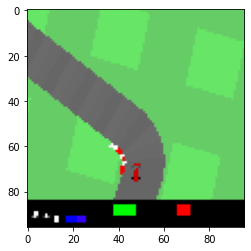

In [1]:
# NO NEED TO MODIFY THIS CELL
# Dependencies for rendering openai gym in colab and enable video recording.
# Remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym[box2d] pyvirtualdisplay piglet > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
import gym
from gym import logger as gymlogger
gymlogger.set_level(40) #error only
from gym.wrappers import Monitor
import tensorflow as tf
import numpy as np
import random, math, glob, io, base64
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
def wrap_env(env):
  """
  Utility functions to enable video recording of gym environment and displaying it
  To enable video, just do "env = wrap_env(env)""
  """
  return Monitor(env, './video', force=True)

# Download example data for training.
import gzip, os, pickle, random
import matplotlib.pyplot as plt
!gdown --id 1AQnMFSRU3qQcHA-ruS8Ahcz-00FmYoi0 # File shared on Peter's gdrive 6MB.
with gzip.open('carracing_behavior.gzip', 'rb') as f:
    states, action_classes = pickle.load(f)

print('\nState data shape (examples, x, y, color):', states.shape)
print('Action data shape (examples, action idx):', action_classes.shape)

# Plot an example state. This is the model input.
print('\nExample state (this is the input to your neural network):')
plt.imshow(states[0, :, :, :])

# The simulator expects a length-3 array corresponding to stear, 
# accellerate, and brake. But I converted the training data actions into a 
# discrete set to frame the problem as classification. This is the set of 
# possible actions. The indices in training data targets (action_classes) 
# correspond to this set of actions. Your agent's act method should
# return one of these, not an integer index.
ACTION_SPACE = [[0, 0, 0],   # no action
                [-1, 0, 0],  # left
                [-1, 0, 1],  # left+brake
                [1, 0, 0],   # right
                [1, 0, 1],   # right+brake
                [0, 1, 0],   # acceleration
                [0, 0, 1], ] # brake

# `Agent` class

## Model: `keras.models.Sequential`

Since training `Agent` entails one input array and one output array, [`Sequential` is a good fit](https://keras.io/guides/sequential_model/).

## Layers

Pairs of convolutional and pooling layers were used first.  The former turns inputs into higher-dimensional outputs, whereas the latter "pools" dimensions to do the opposite.


## Overfitting prevention measures

A `Dropout` layer with a keep rate of `0.5` was used on just before outputs.

This randomly zeroes out certain activations during at each iteration, helping prevent weights from becoming "co-dependent", i.e. fixing one another's errors.







In [2]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from tqdm import tqdm

class Agent:
    def __init__(self):
        # Load previous model if saved
        try:
            self.model = load_model('agent.h5')
        except:
            self.model = None

    def train(self, x, y):
        y_onehot = to_categorical(y) # action_classes are ints, need to make one_hot.
        model = Sequential([
            Input(shape=x[0,...].shape),
            # Conv2D(2**5, (3,3), strides=(2,2), activation='relu'),
            Conv2D(2**5, (3,3), activation='relu'),
            MaxPooling2D(pool_size=(2,2)),#, strides=(2,2)),
            Conv2D(2**5, (3,3), activation='relu'),
            MaxPooling2D(pool_size=(2,2)),#, strides=(2,2)),               

            Flatten(),
            # Dropout to prevent overfitting
            # Dropout(0.8),
            # Dense layer for output; units param == number of outputs.
            Dense(len(ACTION_SPACE), activation='softmax'),
        ])
        
        
        model.compile(
            # Multi-class classification => categorical cross-entropy
            loss      = 'categorical_crossentropy',
            # Adam algorithm for optimized step size progression
            # in adjusting weights
            optimizer = 'adam',
            metrics   = tf.keras.metrics.CategoricalAccuracy()
        )
        # Stop early if overfitting
        cbks = [EarlyStopping(patience=2)]


        model.fit(
            x, y_onehot,
            batch_size=2**10, validation_split=0.1, 
            epochs=100, callbacks=cbks
        )
        model.save('agent.h5') # Reload with model = load_model('agent.h5')
        self.model = model

    def act(self, state):
        """
        Use a model to predict action from input state.
        Inputs
            model: Keras model that takes input of shape (batchsize, 96, 96, 3),
            and outputs array of shape (batchsize, 7), which correpsond to 
            probabilities of the 7 actions in ACTION_SPACE.
            state: Numpy array of shape (96, 96, 3)
        Returns
            action: Numpy vector of shape (3,) corresponds to [turn, accelerate, brake].
        """
        state = np.expand_dims(state, axis=0) # Adds dimension to array (batchsize=1).
        act_values = self.model.predict(state)     # Predicts which action to take.
        action_index = np.argmax(act_values[0]) # Choose action with highest prob.
        # print(act_values)
        action = np.array(ACTION_SPACE[action_index]) # Convert action index to array of len 3.
        assert action.shape == (3,) # [turn, accelerate, brake]
        # print(action)
        return action

agent = Agent()
agent.train(states, action_classes)
agent.model.summary()

Epoch 1/100
10/10 [==============================] - 5s 206ms/step - loss: 59.3826 - categorical_accuracy: 0.3387 - val_loss: 5.6587 - val_categorical_accuracy: 0.5548
Epoch 2/100
10/10 [==============================] - 1s 118ms/step - loss: 5.0864 - categorical_accuracy: 0.4499 - val_loss: 1.5384 - val_categorical_accuracy: 0.5422
Epoch 3/100
10/10 [==============================] - 1s 110ms/step - loss: 1.7372 - categorical_accuracy: 0.4368 - val_loss: 1.2484 - val_categorical_accuracy: 0.5431
Epoch 4/100
10/10 [==============================] - 1s 113ms/step - loss: 1.4343 - categorical_accuracy: 0.4224 - val_loss: 1.2014 - val_categorical_accuracy: 0.4892
Epoch 5/100
10/10 [==============================] - 1s 111ms/step - loss: 1.3147 - categorical_accuracy: 0.4659 - val_loss: 1.1296 - val_categorical_accuracy: 0.5646
Epoch 6/100
10/10 [==============================] - 1s 110ms/step - loss: 1.2454 - categorical_accuracy: 0.4979 - val_loss: 1.1062 - val_categorical_accuracy: 0.57

# Simulate Agent

In [3]:
# NO NEED TO MODIFY THIS CELL
# Run simulation for t timesteps.
NUM_TIMESTEPS = 2000  # Increase this to run simulation longer.
with wrap_env(gym.make("CarRacing-v0")) as env: # Exits env when done.
  observation = env.reset()  # Restarts car at the starting line.
  for t in range(NUM_TIMESTEPS):
    env.render() 
    action = agent.act(observation)
    observation, reward, done, info = env.step(action)
    if done:
      print("Episode finished after {} timesteps".format(t+1))
      break
show_video()  # Video can be downloaded by clicking option in bottom right.

Track generation: 1121..1405 -> 284-tiles track
Episode finished after 327 timesteps
